# Fraud Detection Using AutoEncoders - An Unsupervised Learning Method

## Introduction

In many real life situations, you will encounter where you do not have labeled data and still you need to detect fraudaulent activites. This technique walks you through how to learn features, build a model using unlabeled dataset and helps you to detect frauds.

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

In [9]:
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score,accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_curve,cohen_kappa_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

## Downloading data

In [10]:
!curl https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip -o ../data/creditcardfraud.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.9M  100 65.9M    0     0  75.3M      0 --:--:-- --:--:-- --:--:-- 75.3M


In [19]:
!unzip -o ../data/creditcardfraud.zip -d ../data/

Archive:  ../data/creditcardfraud.zip
  inflating: ../data/creditcard.csv  


## Load and Visualize

In [20]:
dataset = pd.read_csv('../data/creditcard.csv', delimiter=',')

In [21]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Last column represents the class i.e fraud or non-fraud. Let's plot this class against the Frequency to see how the data is distributed. We are not going to use this label as its a non-supervised technique.

Text(0, 0.5, 'Frequency')

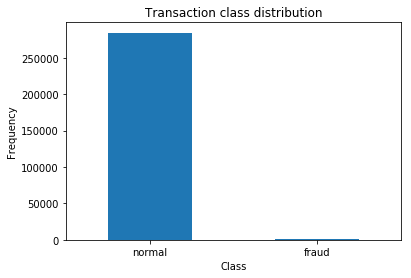

In [22]:
labels = ['normal','fraud']
classes = pd.value_counts(dataset['Class'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

It clearly indicates that its a highly imbalanced dataset.

Let's see all the columns and how data is distributed.

In [23]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Other part to note is that we have two columns Time and Amount which are not scaled. So let's scale them by using standard scaler from sklearn. It reshapes the values between -1 and 1.

All other columns looks ok.

In [24]:
dataset['Time'] = StandardScaler().fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = StandardScaler().fit_transform(dataset['Amount'].values.reshape(-1, 1))

## Split dateset into Train and Test

In [25]:
# 80% for the training set and 20% for testing set
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

train, test = train_test_split(dataset, test_size=TEST_PCT,random_state=RANDOM_SEED)


## Build the Model - AutoEncoder

AutoEncoders are special kind of neural networks, where your input is 'x' and you have your output as 'x' as well. What this really means is that we are trying to learn a function, where the input and output are the same.

The function f(x), that we are going to learn is approximately equal to x 

![](../images/function.png)

![](../images/Autoencoder_structure.png)

Few things to note. 

- We are reducing the number of nodes, which will force network to learn the features from the dataset. Intuition being that this "code" is a set of abstracted features which represents or creates a fingerprint for "fraud" or a "non-fraud" activitiy.
- Since we are starting with the input 'x', reducing into a abstracted features and then reconstructing back the 'x' means we really don't need a labeled dataset. 
- The "code" is intutively a representation of abstracted features. In case of credit card frauds features abstraction would be "when does a fraud occur?". It can be a credit card transaction by the same person, from multiple places, using the same credit card etc.

Here is another intutive representation, we provide input as an image and the network will try to reconstruct the same image. Of course it will be different, so we will find out what's the reconstruction error and we try to reduce with each training dataset.

![](../images/AutoEncoder.png)

For our credit card dataset, we are going to get all the non-fraudulent data and will try to re-create the same. During this process the network should try to learn a unique representation of what's a non-fradulent activity. Once the model is trained with whats 'normal' that means anything which does not match this normal representation can be declared as abnormal. 

For inference, we are going to give both fraud and non-fraud data to the model. Model prediction will give us the %age reconstruction error. This is where we set the threshold which let's domain expert define what tolerance is ok consider normal and when to declare as abnormal data. 

In [26]:
train_x = train.loc[train['Class'] == 0]
train_x = train_x.drop(['Class'], axis=1)

For input with testing dataset, we would need all the columns except column 'Class'. We will predict on this input and compare with the output column 'Class'. 

Let's split into input and expected output

In [27]:
test_y = test['Class']
test_x = test.drop(['Class'], axis=1)

Let's check one more time, what columns are being used in the training dataset

In [28]:
print(train_x.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


In [29]:
print('Shapes are: Train=',train.shape,' Test=',test.shape)

Shapes are: Train= (227845, 31)  Test= (56962, 31)


## Build the Model - AutoEncoder

We are going to create two layers both for encoders and decoders. 

First layer will have the dimension close to half of the input dimension to the network and 2nd layer will be half of the 1st layer. In this case it will be 14 and 7

In [68]:
# this is the size of our encoded representations
nb_epoch = 20
batch_size = 128
input_dim = train_x.shape[1]
encoding_dim = int(input_dim / 2) - 1
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="tanh")(encoder)
decoder = Dense(encoding_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 14)                434       
_________________________________________________________________
dense_16 (Dense)             (None, 7)                 105       
_________________________________________________________________
dense_17 (Dense)             (None, 14)                112       
_________________________________________________________________
dense_18 (Dense)             (None, 30)                450       
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________


## Train the AutoEncoder Model

In [69]:
cp = ModelCheckpoint(filepath="../model/autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='../logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 181974 samples, validate on 45494 samples
Epoch 1/20
181974/181974 [==============================] - 4s 22us/step - loss: 0.7648 - acc: 0.4002 - val_loss: 0.6811 - val_acc: 0.4298
Epoch 2/20
181974/181974 [==============================] - 3s 18us/step - loss: 0.6677 - acc: 0.4212 - val_loss: 0.6402 - val_acc: 0.4105
Epoch 3/20
181974/181974 [==============================] - 3s 18us/step - loss: 0.6394 - acc: 0.4141 - val_loss: 0.6208 - val_acc: 0.4145
Epoch 4/20
181974/181974 [==============================] - 3s 18us/step - loss: 0.6248 - acc: 0.4259 - val_loss: 0.6093 - val_acc: 0.4339
Epoch 5/20
181974/181974 [==============================] - 3s 18us/step - loss: 0.6138 - acc: 0.4402 - val_loss: 0.5984 - val_acc: 0.4448
Epoch 6/20
181974/181974 [==============================] - 3s 18us/step - loss: 0.6041 - acc: 0.4469 - val_loss: 0.5892 - val_acc: 0.4495
Epoch 7/20
181974/181974 [==============================] - 3s 18us/step - loss: 0.5963 - acc: 0.4526 - val_loss: 0

### Plot training and validation losses

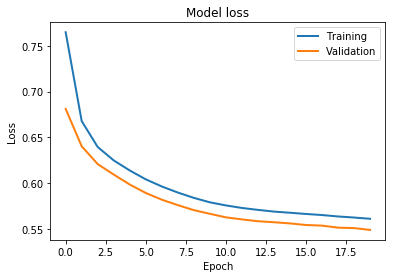

In [70]:
plt.plot(history['loss'], linewidth=2, label='Training')
plt.plot(history['val_loss'], linewidth=2, label='Validation')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

## Predicting with AutoEncoder

We are going to calculate the mean squared error between predicted and the expected values. This will be our reconstruction error

In [71]:
y_pred = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - y_pred, 2), axis=1)

Let's see how is reconstuction error w.r.t predicted class

In [72]:
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': test_y})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.590379,0.002019
std,3.406884,0.044887
min,0.011534,0.000000
25%,0.120668,0.000000
50%,0.206539,0.000000
75%,0.421927,0.000000
max,188.458481,1.000000


## Reconstruction error without fraud

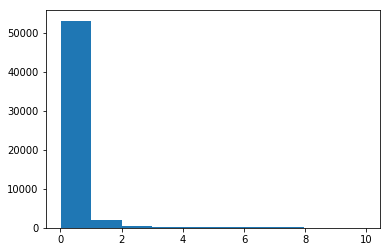

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)


## Reconstruction error with fraud

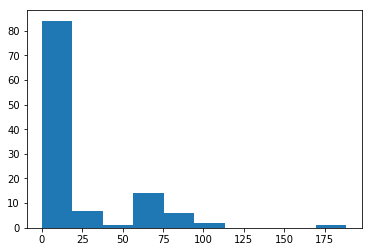

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

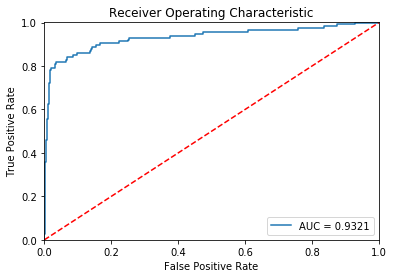

In [75]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

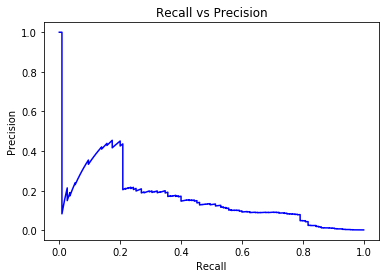

In [76]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

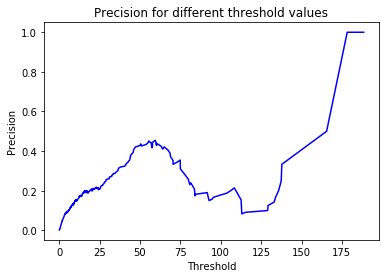

In [77]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

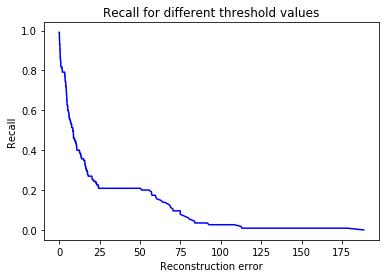

In [78]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [91]:
threshold = 5

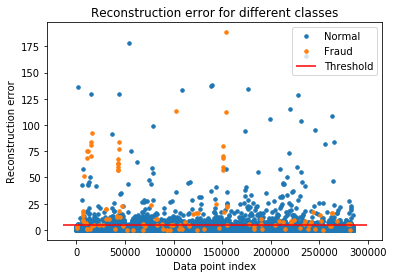

In [92]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [93]:

LABELS = ["Normal", "Fraud"]

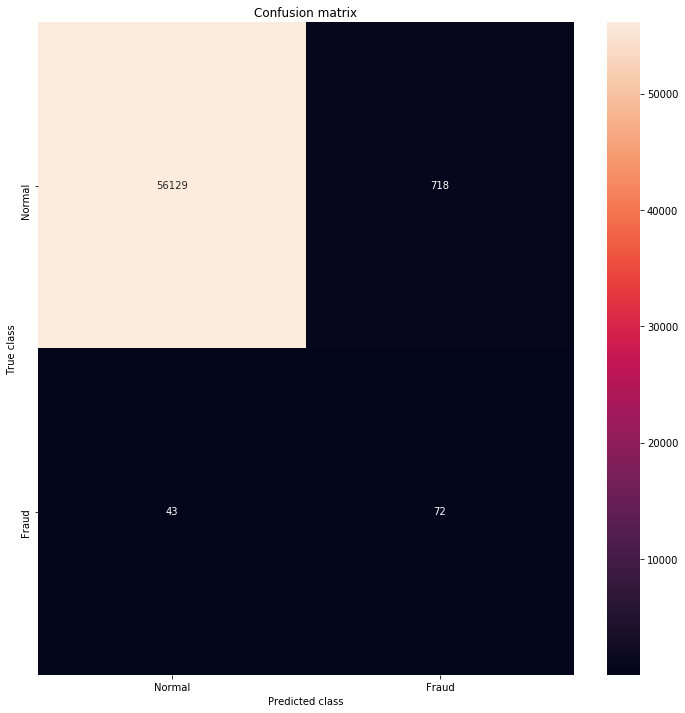

In [94]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [95]:
precision_score(y_true=error_df.true_class, y_pred=y_pred)
accuracy_score(y_true=error_df.true_class, y_pred=y_pred)

0.9866402162845406

In [96]:
print ("")
print ("Classification Report: ")
print (classification_report(y_true=error_df.true_class, y_pred=y_pred))

print ("")
print ("Accuracy Score: ", accuracy_score(y_true=error_df.true_class, y_pred=y_pred))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56847
           1       0.09      0.63      0.16       115

    accuracy                           0.99     56962
   macro avg       0.55      0.81      0.58     56962
weighted avg       1.00      0.99      0.99     56962


Accuracy Score:  0.9866402162845406


## Data Acknowledgements


The dataset used to demonstrated the fraud detection solution has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project We cite the following works:

- Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
- Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon
- Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE
- Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)
- Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier
- Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing